# Trading Strategy

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import all the packages

In [11]:
import pandas as pd
import numpy as np
from DataLoader import DataLoader
import utils
import polars as pl
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt

### Load Data using `DataLoader`

In [12]:
loader = DataLoader("./data", "csv")
df = loader.load_dates("20060302", "20230831").to_pandas().set_index('Date')

### Download Market Data from Yahoo Finance

In [13]:
vxx = yf.download('VXX')

[*********************100%***********************]  1 of 1 completed


In [14]:
prices = vxx[['Adj Close']]
prices.columns = ['price']
prices.head()

,price
Date,
2018-01-25,1770.239990
2018-01-26,1770.239990
2018-01-29,1893.119995
2018-01-30,1955.199951
2018-01-31,1961.599976


prices are available starting from `2018`

# Backtesting simple idea: mean reverting on H

#### Load previously calculated parameters

In [15]:
params = pd.read_parquet('./params/params_futures_diffevo_20060224_20230831.parquet')
params.coulmns = ['date'] + list(params.columns)[1:]
params = params.dropna()
params.head()

/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_9114/1817061583.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  params.coulmns = ['date'] + list(params.columns)[1:]


,H,eta,err_code
2006-03-27,0.144169,1.017627,0.0
2006-03-28,0.127290,1.046365,0.0
2006-03-29,0.135070,1.030386,0.0
2006-03-30,0.136857,1.020660,0.0
2006-03-31,0.087517,1.186392,0.0


# Strategy:
- 3 days moving average against the rolling median
- use a smoothed estimate as signal

In [16]:
window = 252
MA_smooth = 3
center = False
params['median'] = params['H'].rolling(window=window, center=center).median()  # best median
params['H_true'] = params['H'].rolling(window=MA_smooth).mean()  # smoothed H

In [17]:
# one line np.where 
params['signal'] = np.where(
    params['H_true'] > params['median'], -1,
    np.where(params['H_true'] < params['median'], 1, 0)
)
params['signal'] = params['signal'].shift(1)
params.head()

,H,eta,err_code,median,H_true,signal
2006-03-27,0.144169,1.017627,0.0,NaN,NaN,NaN
2006-03-28,0.127290,1.046365,0.0,NaN,NaN,0.0
2006-03-29,0.135070,1.030386,0.0,NaN,0.135510,0.0
2006-03-30,0.136857,1.020660,0.0,NaN,0.133072,0.0
2006-03-31,0.087517,1.186392,0.0,NaN,0.119815,0.0


### Compute P&L

In [19]:
data = params.join(prices)
data['rets'] = data['price'].pct_change()
data['pnl'] = data['rets'] * data['signal']
data = data.dropna()

In [21]:
data.head()

,H,eta,err_code,median,H_true,signal,price,rets,pnl
2018-01-26,0.168856,1.844915,0.0,0.11163,0.155926,-1.0,1770.239990,0.000000,-0.000000
2018-01-29,0.061243,2.472309,0.0,0.11098,0.125206,-1.0,1893.119995,0.069414,-0.069414
2018-01-30,0.043525,2.857849,0.0,0.11098,0.091208,-1.0,1955.199951,0.032792,-0.032792
2018-01-31,0.085371,2.201180,0.0,0.11098,0.063379,1.0,1961.599976,0.003273,0.003273
2018-02-01,0.125066,1.961059,0.0,0.11163,0.084654,1.0,1862.848022,-0.050343,-0.050343


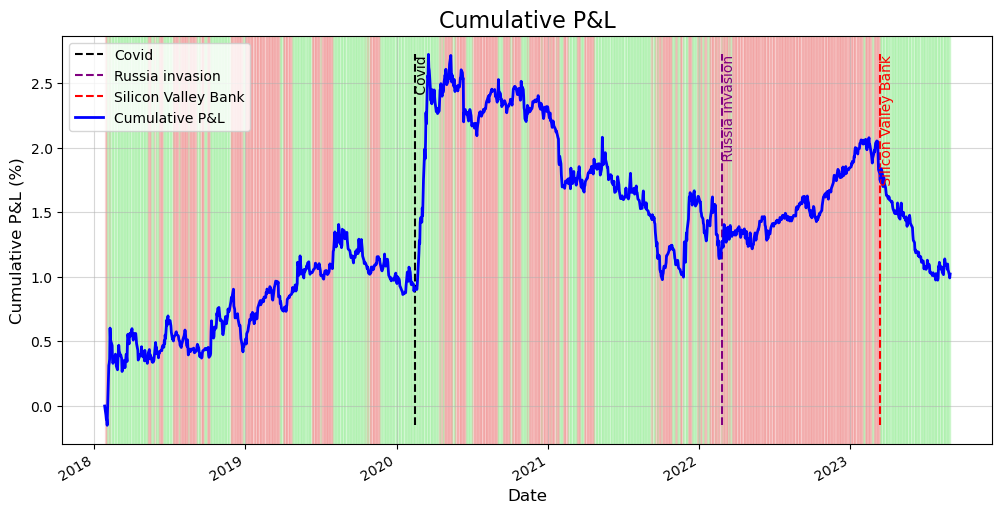

In [ ]:
# Define risk events
risks = {
    'Covid': dt.date(2020, 2, 15),
    'Russia invasion': dt.date(2022, 2, 24),
    'Silicon Valley Bank': dt.date(2023, 3, 13)
}

# Define colors for each risk event
risk_colors = ['black', 'purple', 'red']  

fig, ax = plt.subplots(figsize=(12, 6))
cum_pnl = data['pnl'].dropna().cumsum()

# Add background colors based on the signal
for i in range(len(data)):
    if i > 0:  
        if data['signal'].iloc[i - 1] == 1:
            ax.axvspan(data.index[i - 1], data.index[i], color='lightgreen', alpha=0.2)
        elif data['signal'].iloc[i - 1] == -1:
            ax.axvspan(data.index[i - 1], data.index[i], color='lightcoral', alpha=0.2)

# Add vertical lines for each risk date with specific colors and annotate the events
for (name, dd), color in zip(risks.items(), risk_colors):
    ax.plot([dd] * 2, [cum_pnl.min(), cum_pnl.max()], ls='--', color=color, label=name, marker=None)
    ax.text(dd, cum_pnl.max(), f' {name}', color=color, fontsize=10, va='top', ha='left', rotation=90)

# Plot the PnL line
data['pnl'].dropna().cumsum().plot(ax=ax, color='blue', linewidth=2, label="Cumulative P&L")

# Formatting
ax.set_title("Cumulative P&L", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Cumulative P&L (%)", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True, alpha=0.5)
plt.savefig('./Plots/P&L_short')
plt.show()

# Short Volatility strategy

In [ ]:
window = 252
MA_smooth = 3
center = False
params['median'] = params['H'].rolling(window=window, center=center).median()  # best median
params['H_true'] = params['H'].rolling(window=MA_smooth).mean()  # smoothed H

### create signal

In [23]:
# one line np.where 
params['signal'] = np.where(
    params['H_true'] > params['median'], -1,
    np.where(params['H_true'] < params['median'], 0, 0)
)
params['signal'] = params['signal'].shift(1)
params.head()

,H,eta,err_code,median,H_true,signal
2006-03-27,0.144169,1.017627,0.0,NaN,NaN,NaN
2006-03-28,0.127290,1.046365,0.0,NaN,NaN,0.0
2006-03-29,0.135070,1.030386,0.0,NaN,0.135510,0.0
2006-03-30,0.136857,1.020660,0.0,NaN,0.133072,0.0
2006-03-31,0.087517,1.186392,0.0,NaN,0.119815,0.0


## compute pnl

In [25]:
data = params.join(prices)
data['rets'] = data['price'].pct_change()
data['pnl'] = data['rets'] * data['signal']
data = data.dropna()
data.head()

,H,eta,err_code,median,H_true,signal,price,rets,pnl
2018-01-26,0.168856,1.844915,0.0,0.11163,0.155926,-1.0,1770.239990,0.000000,-0.000000
2018-01-29,0.061243,2.472309,0.0,0.11098,0.125206,-1.0,1893.119995,0.069414,-0.069414
2018-01-30,0.043525,2.857849,0.0,0.11098,0.091208,-1.0,1955.199951,0.032792,-0.032792
2018-01-31,0.085371,2.201180,0.0,0.11098,0.063379,0.0,1961.599976,0.003273,0.000000
2018-02-01,0.125066,1.961059,0.0,0.11163,0.084654,0.0,1862.848022,-0.050343,-0.000000


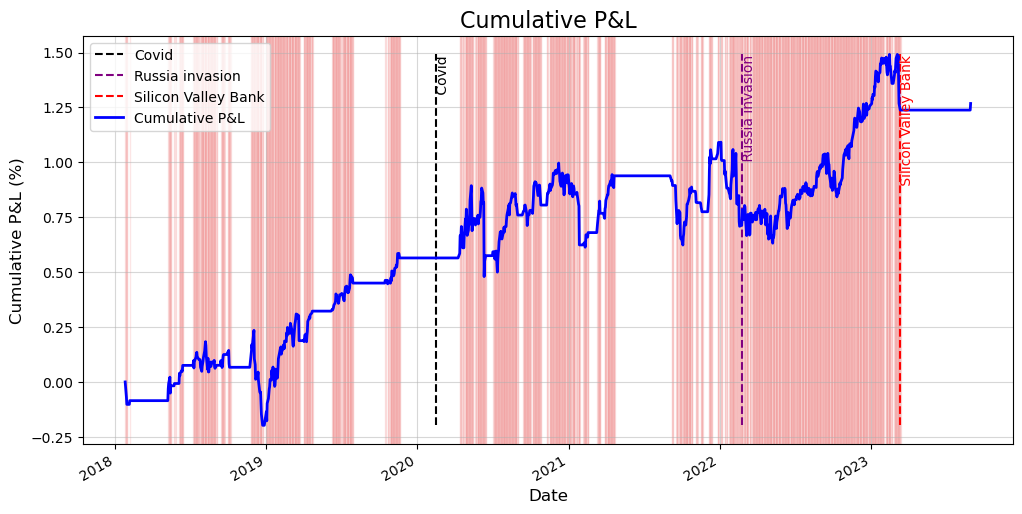

In [26]:
# Define risk events
risks = {
    'Covid': dt.date(2020, 2, 15),
    'Russia invasion': dt.date(2022, 2, 24),
    'Silicon Valley Bank': dt.date(2023, 3, 13)
}

# Define colors for each risk event
risk_colors = ['black', 'purple', 'red']  

fig, ax = plt.subplots(figsize=(12, 6))
cum_pnl = data['pnl'].dropna().cumsum()

# Add background colors based on the signal
for i in range(len(data)):
    if i > 0:  
        if data['signal'].iloc[i - 1] == 1:
            ax.axvspan(data.index[i - 1], data.index[i], color='lightgreen', alpha=0.2)
        elif data['signal'].iloc[i - 1] == -1:
            ax.axvspan(data.index[i - 1], data.index[i], color='lightcoral', alpha=0.2)

# Add vertical lines for each risk date with specific colors and annotate the events
for (name, dd), color in zip(risks.items(), risk_colors):
    ax.plot([dd] * 2, [cum_pnl.min(), cum_pnl.max()], ls='--', color=color, label=name, marker=None)
    ax.text(dd, cum_pnl.max(), f' {name}', color=color, fontsize=10, va='top', ha='left', rotation=90)

# Plot the PnL line
data['pnl'].dropna().cumsum().plot(ax=ax, color='blue', linewidth=2, label="Cumulative P&L")

# Formatting
ax.set_title("Cumulative P&L", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Cumulative P&L (%)", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True, alpha=0.5)
plt.savefig('./Plots/P&L_short')
plt.show()